In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import Counter
%matplotlib notebook
np.set_printoptions(suppress=True, precision=3)

In [2]:
with open('hon_matches.pkl', 'rb') as db:
    matches = pickle.load(db)
print('Total Matches:', len(matches))

Total Matches: 100328


In [3]:
# try removing matches that do not have total 10 players
# or have duplicate heroes
remove_incomplete = False
removes = []
dup_removes = []
for k, v in matches.items():
    ll = len(v['legion'])
    hl = len(v['hellbourne'])
    if remove_incomplete and ll + hl < 10:
        removes.append(k)
    # checking for duplicate heroes match
    lls = len(set(v['legion']))
    hls = len(set(v['hellbourne']))
    if lls < ll or hls < hl:
        dup_removes.append(k)
removes = set(removes)
for key in removes:
    del matches[key]
print('Incomplete Matches Removed:', len(removes))
dup_removes = set(dup_removes) & set(matches.keys())
for key in dup_removes:
    del matches[key]
print('Duplicate-Heroes Matches Removed:', len(dup_removes))
print('Remaining Matches:', len(matches))

Incomplete Matches Removed: 0
Duplicate-Heroes Matches Removed: 581
Remaining Matches: 99747


In [4]:
X = []
for i, item in enumerate(matches.items()):
    if i == 5:
        break
    print(item)
    X.append(item[1])

(147849216, {'legion': [226, 195, 15, 9, 94], 'winner': 1, 'concedes': 0, 'hellbourne': [117, 43, 243, 167, 41], 'secs': 1955})
(147849218, {'legion': [102, 125, 168, 30, 209], 'winner': 0, 'concedes': 5, 'hellbourne': [25, 244, 10, 246, 16], 'secs': 2077})
(147849220, {'legion': [117, 166, 226, 6, 230], 'winner': 1, 'concedes': 5, 'hellbourne': [209, 116, 24, 202, 228], 'secs': 2074})
(147849226, {'legion': [12, 4, 102, 243, 207], 'winner': 0, 'concedes': 5, 'hellbourne': [202, 117, 10, 161, 163], 'secs': 2017})
(147849227, {'legion': [108, 110, 161, 239, 233], 'winner': 1, 'concedes': 0, 'hellbourne': [94, 248, 31, 43, 240], 'secs': 3268})


In [5]:
AVAIL_HEROES = 260 # actually 134 but extra for future
def vectorize_matches(matches, include_Y=True):
    legion_vec = np.zeros([len(matches), AVAIL_HEROES])
    hellbourne_vec = np.zeros([len(matches), AVAIL_HEROES])
    if include_Y:
        winner = np.zeros([len(matches), 1])
        concede = np.zeros([len(matches), 1])
        secs = np.zeros([len(matches), 1])
    for m, match in enumerate(matches):
        for hero_id in match['legion']:
            legion_vec[m, hero_id] = 1.
        for hero_id in match['hellbourne']:
            hellbourne_vec[m, hero_id] = 1.
        if include_Y:
            if match['winner']:
                winner[m, 0] = 1.
            if match['concedes']:
                concede[m, 0] = 1.
            secs[m, 0] = match['secs']
    x = np.concatenate([legion_vec, hellbourne_vec], axis=1)
    if include_Y:
        y = np.concatenate([winner, concede, secs], axis=1)
    return (x, y) if include_Y else x

# Serious time

In [6]:
X, Y = vectorize_matches(matches.values())
X.shape, Y.shape

((99747, 520), (99747, 3))

In [7]:
with open('heroes_name.pkl', 'rb') as f:
    heroes_dict = pickle.load(f)
heroes_dict[125]

{'attacktype': 'ranged',
 'description': 'A powerful wizard once owned a pet turtle.  Each day, the turtle watched and mimicked as the wizard practiced his spells.  One day, the turtle fell into a magical pool and was transformed into more than a mere turtle. Now, centuries after his master died, Bubbles lives on, fighting the forces of evil.',
 'disp_name': 'Bubbles',
 'hero_id': '125',
 'primaryattribute': 'Intelligence',
 'team': 'Legion'}

In [8]:
def hero_id_to_name(hero_id):
    return heroes_dict[hero_id]['disp_name']
hero_id_to_name(125)

'Bubbles'

In [9]:
def hero_name_to_id(name):
    if not name:
        return None
    name = name.lower()
    for id, hero in heroes_dict.items():
        if name in hero['disp_name'].lower():
            return id, hero['disp_name']
    return None
hero_name_to_id('BUB')

(125, 'Bubbles')

In [10]:
from operator import itemgetter
# returns a hero that maximize win probability in a given team
# if 'optimal' is false, it will return a hero that minimize win probability
def optimal_hero_choice(model, match, hellbourne_side=False, as_list=True, as_name=True, optimal=True):
    legion = match['legion']
    hellbourne = match['hellbourne']
    team_ids = hellbourne if hellbourne_side else legion
    hypothesis = []
    for id in set(heroes_dict.keys()) - set(legion + hellbourne): # all choosable hero ids
        team_ids.append(id)
        x = vectorize_matches([match], include_Y=False)
        team_ids.pop()
        p = model.predict(x, verbose=0)[0]
        hero = id
        if as_name:
            hero = hero_id_to_name(hero)
        hypothesis.append((hero, p[0, 1 if hellbourne_side else 0]))
    extrema = max if optimal else min
    return sorted(hypothesis, key=itemgetter(1), reverse=optimal) if as_list else extrema(hypothesis, key=itemgetter(1))

In [11]:
def humanize(xrow):
    legion, hellbourne = [], []
    for i, el in enumerate(xrow):
        if el:
            if i < AVAIL_HEROES:
                name = hero_id_to_name(i)
                legion.append(name)
            else:
                name = hero_id_to_name(i - AVAIL_HEROES)
                hellbourne.append(name)
    return {'legion': legion, 'hellbourne': hellbourne}

# Data Exploration

In [12]:
# which team won more? Hellbourne!
Counter(Y[:,0]), Y.mean(axis=0)

(Counter({0.0: 46524, 1.0: 53223}), array([    0.534,     0.645,  1946.186]))

In [13]:
played = [] # played heroes
for i, item in enumerate(matches.items()):
    v = item[1]
    if 0 in v['legion']:
        print(item)
    if 0 in v['hellbourne']:
        print(item)
    played.extend(v['legion'])
    played.extend(v['hellbourne'])
len(played)

941122

In [14]:
Counter(played).most_common()

[(6, 27917),
 (38, 24532),
 (43, 24474),
 (164, 22592),
 (242, 21712),
 (117, 18341),
 (10, 18050),
 (166, 17556),
 (163, 15827),
 (236, 15822),
 (226, 15198),
 (41, 13356),
 (249, 13206),
 (24, 12761),
 (94, 12755),
 (15, 12741),
 (104, 12601),
 (27, 12503),
 (44, 11818),
 (106, 11722),
 (31, 11547),
 (103, 11055),
 (125, 10157),
 (192, 10144),
 (3, 9893),
 (8, 9824),
 (230, 9802),
 (21, 9739),
 (209, 9520),
 (194, 9241),
 (91, 8817),
 (220, 8687),
 (126, 8628),
 (4, 8612),
 (39, 8456),
 (161, 8414),
 (216, 8341),
 (92, 8325),
 (195, 8251),
 (228, 8172),
 (244, 8113),
 (167, 8068),
 (12, 7842),
 (120, 7821),
 (205, 7818),
 (250, 7594),
 (108, 7409),
 (210, 7367),
 (110, 7320),
 (222, 7225),
 (114, 7160),
 (168, 7004),
 (13, 6979),
 (14, 6802),
 (219, 6647),
 (5, 6614),
 (202, 6574),
 (34, 6572),
 (128, 6292),
 (18, 6196),
 (20, 6087),
 (122, 6023),
 (7, 5925),
 (16, 5852),
 (26, 5841),
 (42, 5832),
 (2, 5816),
 (89, 5808),
 (197, 5559),
 (121, 5474),
 (214, 5467),
 (40, 5402),
 (196, 

In [15]:
[(hero_id_to_name(id), freq) for (id, freq) in Counter(played).most_common() if id != 0]

[('Devourer', 27917),
 ('Legionnaire', 24532),
 ('Demented Shaman', 24474),
 ('Bombardier', 22592),
 ('Deadlift', 21712),
 ('Rampage', 18341),
 ('Nymphora', 18050),
 ('Myrmidon', 17556),
 ('Flint Beastwood', 15827),
 ('Klanx', 15822),
 ('Solstice', 15198),
 ('Nomad', 13356),
 ('Adrenaline', 13206),
 ('Soulstealer', 12761),
 ('Pyromancer', 12755),
 ('Swiftblade', 12741),
 ('Wretched Hag', 12601),
 ('Voodoo Jester', 12503),
 ('Scout', 11818),
 ('Magmus', 11722),
 ('Zephyr', 11547),
 ('Valkyrie', 11055),
 ('Bubbles', 10157),
 (' \t\tAmun-Ra', 10144),
 ('Behemoth', 9893),
 ('Slither', 9824),
 ('Bushwack', 9802),
 ('Pollywog Priest', 9739),
 ('Lord Salforis', 9520),
 ('Parasite', 9241),
 ('Puppet Master', 8817),
 ('Riftwalker', 8687),
 ('Fayde', 8628),
 ('Chronos', 8612),
 ('Predator', 8456),
 ('The Gladiator', 8414),
 ('Gunblade', 8341),
 ('Arachna', 8325),
 ('Emerald Warden', 8251),
 ('Grinex', 8172),
 ('Skrap', 8113),
 ('Dampeer', 8068),
 ('Glacius', 7842),
 ('Witch Slayer', 7821),
 ('Mi

In [16]:
# how many players are there in a game?
players = Counter(X.sum(axis=1))
players

Counter({1.0: 1358,
         2.0: 2972,
         3.0: 256,
         4.0: 875,
         5.0: 97,
         6.0: 385,
         7.0: 231,
         8.0: 1243,
         9.0: 8104,
         10.0: 84226})

<IPython.core.display.Javascript object>


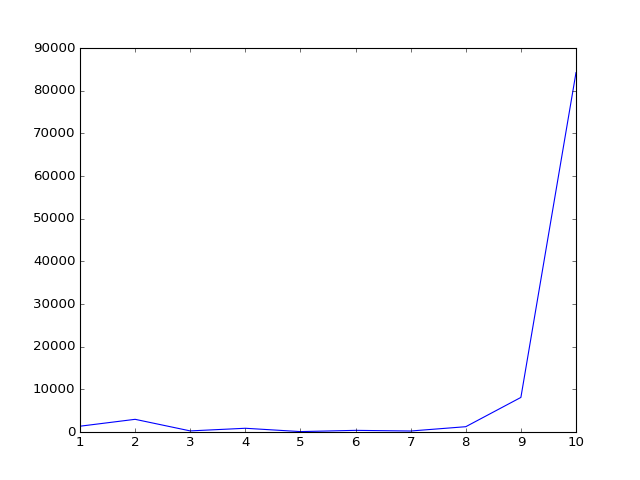

In [17]:
plt.plot(list(players.keys()), list(players.values()))

# Machine Learning

In [18]:
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.91)
X_train.shape, Y_test.shape

((90769, 520), (8978, 3))

In [19]:
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, ELU, Reshape, Convolution2D, Flatten, Permute, BatchNormalization, Input
from keras.regularizers import l2, activity_l2
hero_input = Input(shape=[2 * AVAIL_HEROES], name='hero_input')
h = Reshape([1, 2, AVAIL_HEROES], input_shape=[AVAIL_HEROES*2,])(hero_input)
h = Permute([2, 3, 1])(h)
h = Convolution2D(135, 1, AVAIL_HEROES, border_mode='valid')(h) # learn to represent 135 heroes from 260-d vector
# h = ELU()(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)
h = Convolution2D(64, 1, 1, border_mode='valid')(h)
# h = ELU()(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)
h = Flatten()(h)
h = Dense(128)(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)
h = Dropout(0.5)(h)
h = Dense(128)(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)
h = Dropout(0.5)(h)
h = Dense(128)(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)
logit = Dropout(0.5)(h)
out_winner = Dense(output_dim=2, activation='softmax', name='out_winner')(logit) # 0 for legion and 1 for hellbourne team
out_concede = Dense(output_dim=1, activation='sigmoid', name='out_concede')(logit) # would the loser concede ?
out_secs = Dense(output_dim=1, name='out_secs')(logit) # how many seconds would the game last ?
model = Model([hero_input], [out_winner, out_concede, out_secs])
loss = ['sparse_categorical_crossentropy', 'binary_crossentropy', 'mean_squared_error']
metrics = {
    'out_winner': 'accuracy',
    'out_concede': 'accuracy',
    'out_secs': 'mean_absolute_error'
}
loss_weights = {
    'out_winner': 2.,
    'out_concede': 1.,
    'out_secs': 1./600000 # mean squared loss is so high we have to penalize it, otherwise, it would steal all computations
}
model.compile(loss=loss, optimizer='adam', metrics=metrics, loss_weights=loss_weights)
hist = model.fit(X_train, np.split(Y_train, 3, axis=1), batch_size=32, nb_epoch=10, verbose=1, validation_split=0.075)

Using TensorFlow backend.


Train on 83961 samples, validate on 6808 samples
Epoch 1/10
83961/83961 [==============================] - 50s - loss: 8.2876 - out_winner_loss: 0.7113 - out_concede_loss: 0.6625 - out_secs_loss: 3721518.4325 - out_winner_acc: 0.5432 - out_concede_acc: 0.6352 - out_secs_mean_absolute_error: 1788.0240 - val_loss: 5.8787 - val_out_winner_loss: 0.6726 - val_out_concede_loss: 0.6368 - val_out_secs_loss: 2338082.4317 - val_out_winner_acc: 0.5830 - val_out_concede_acc: 0.6763 - val_out_secs_mean_absolute_error: 1371.0248
Epoch 2/10
83961/83961 [==============================] - 48s - loss: 3.6353 - out_winner_loss: 0.6977 - out_concede_loss: 0.6428 - out_secs_loss: 958283.1485 - out_winner_acc: 0.5595 - out_concede_acc: 0.6637 - out_secs_mean_absolute_error: 766.0353 - val_loss: 2.7472 - val_out_winner_loss: 0.6667 - val_out_concede_loss: 0.6474 - val_out_secs_loss: 459887.2535 - val_out_winner_acc: 0.5971 - val_out_concede_acc: 0.6783 - val_out_secs_mean_absolute_error: 534.3327
Epoch 3/10


In [20]:
model.summary()
model.save('honnet_brain.h5')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
hero_input (InputLayer)          (None, 520)           0                                            
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 1, 2, 260)     0           hero_input[0][0]                 
____________________________________________________________________________________________________
permute_1 (Permute)              (None, 2, 260, 1)     0           reshape_1[0][0]                  
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 2, 1, 135)     35235       permute_1[0][0]                  
___________________________________________________________________________________________

In [21]:
loss_and_metrics = model.evaluate(X_test, np.split(Y_test, 3, axis=1), batch_size=32, verbose=1)
loss_and_metrics

8978/8978 [==============================] - 1s     


[2.646847456381618,
 0.6659679257489971,
 0.61572256370944045,
 419513.42712742259,
 0.60091334371583771,
 0.68868344844277229,
 519.70311211041917]

In [26]:
from collections import Counter
Counter(Y[:, 0]), Counter(Y[:, 1]) # win team and concede counts

(Counter({0.0: 46524, 1.0: 53223}), Counter({0.0: 35444, 1.0: 64303}))

<IPython.core.display.Javascript object>


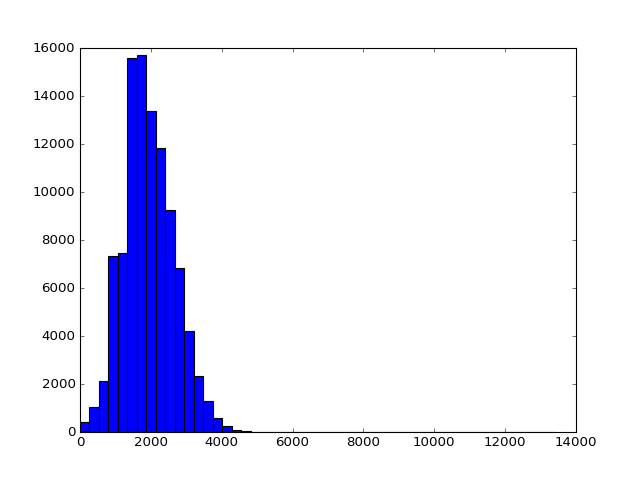

(array([   397.,   1054.,   2142.,   7322.,   7453.,  15571.,  15725.,
         13370.,  11854.,   9232.,   6817.,   4202.,   2342.,   1290.,
           564.,    250.,    100.,     35.,     14.,      5.,      3.,
             1.,      2.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      1.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             1.]),
 array([     0. ,    267.7,    535.4,    803.1,   1070.8,   1338.5,
          1606.2,   1873.9,   2141.6,   2409.3,   2677. ,   2944.7,
          3212.4,   3480.1,   3747.8,   4015.5,   4283.2,   4550.9,
          4818.6,   5086.3,   5354. ,   5621.7,   5889.4,   6157.1,
          6424.8,   6692.5,   6960.2,   7227.9,   7495.6,   7763.3,
          8031. ,   8298.7,   8566.4,   8834.1,   9101.8,   9369.5,
          9637.2,   9904.9,  10172.6,  10440.3,  10708. ,  10975.7,
        

In [24]:
plt.hist(Y[:, -1], bins=50) # lasting time in secs

In [27]:
pred = model.predict(X_test[:10, :])
# prediction is [legion_win_prob, hellbourne_win_prob, loser_concede_prob, estimated_game_time_in_secs]
np.concatenate(pred, 1), Y_train[:10, :]

(array([[    0.751,     0.249,     0.685,  2029.242],
        [    0.48 ,     0.52 ,     0.721,  2076.547],
        [    0.604,     0.396,     0.704,  2108.764],
        [    0.244,     0.756,     0.546,  1593.297],
        [    0.571,     0.429,     0.702,  2091.284],
        [    0.51 ,     0.49 ,     0.701,  2135.393],
        [    0.56 ,     0.44 ,     0.709,  2003.555],
        [    0.578,     0.422,     0.666,  2133.898],
        [    0.627,     0.373,     0.748,  1972.441],
        [    0.72 ,     0.28 ,     0.705,  1847.044]], dtype=float32),
 array([[    0.,     0.,  1633.],
        [    1.,     1.,  1720.],
        [    1.,     1.,  2142.],
        [    0.,     0.,  2086.],
        [    1.,     0.,  1913.],
        [    1.,     1.,  1288.],
        [    1.,     0.,   582.],
        [    1.,     0.,  2553.],
        [    0.,     1.,  1011.],
        [    1.,     1.,  1600.]]))

In [28]:
humanize(X_test[0])

{'hellbourne': ['Doctor Repulsor', 'Flux', 'Revenant', 'Solstice', 'Apex'],
 'legion': ['Moon Queen', 'Legionnaire', 'Nomad', 'Torturer', 'Grinex']}

# Inference

In [29]:
def inputName():
    name = input('Hero Name: ')
    hero_id, hero_name = hero_name_to_id(name)
    return hero_id, hero_name

In [30]:
legion = []
hellbourne = []
hellbourne_bool = 0
match = [{'legion': legion, 'hellbourne': hellbourne}]

In [42]:
hellbourne_bool = not hellbourne_bool
'Hellbourne' if hellbourne_bool else 'Legion'

'Legion'

In [37]:
hero_id, hero_name = inputName()
if hero_id is not None:
    print('Hero:', hero_name)
    if hellbourne_bool:
        hellbourne.append(hero_id)
    else:
        legion.append(hero_id)
    x = vectorize_matches(match, include_Y=False)
    print('Team:', humanize(x[0]))
    proba = model.predict(x, verbose=0)
    print('Proba:', np.concatenate(proba, axis=1))

Hero Name: parallax
Hero: Parallax
Team: {'legion': ['Fayde', 'Oogie', 'Parallax'], 'hellbourne': ['Magebane', 'Martyr']}
Proba: [[    0.782     0.218     0.241  1249.441]]


In [44]:
# selecting an optimal hero for the current team
choice = optimal_hero_choice(model, match[0], hellbourne_side=hellbourne_bool, as_list=False, as_name=False, optimal=True)
print(choice, hero_id_to_name(choice[0]))
team_ids = hellbourne if hellbourne_bool else legion
team_ids.append(choice[0])
match = [{'legion': legion, 'hellbourne': hellbourne}]
x = vectorize_matches(match, include_Y=False)
print('Team:', humanize(x[0]))
proba = model.predict(x, verbose=0)
print('Proba:', np.concatenate(proba, axis=1))

(102, 0.65384871) Andromeda
Team: {'legion': ['Nymphora', 'Andromeda', 'Fayde', 'Oogie', 'Parallax'], 'hellbourne': ['Soulstealer', 'Magebane', 'Empath', 'Martyr', 'Deadlift']}
Proba: [[    0.654     0.346     0.722  1809.483]]
